In [49]:
import pandas as pd
import numpy as np
import yaml
import sys
import warnings
import ast

import pandas as pd
import plotly.figure_factory as ff
import plotly.subplots as sp
import plotly.express as px

import plotter as plot
import matplotlib.pyplot as plt

from pathlib import Path

from Stocks import Stock
from Portfolio import Portfolio
import distributions as dt
import returns as rt
import financial_ratios as fr
import optimizers as opt
import numpy as np
import prophet_helpers as ph
import timestamps as ts
import seaborn as sns
import montecarlo as mc


import scipy.stats as stats
from prophet import Prophet
from scipy.stats import lognorm

import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd




warnings.simplefilter(action='ignore')

def read_yaml(file_name): 
    with open(file_name) as file:
        yaml_data= yaml.safe_load(file)
    return yaml_data


def common_random_numbers(size, seed=10):
    np.random.seed(seed)
    return np.random.rand(size)

def plot_multiple_peformance_distributions(performance_of_portfolio_configs_df, combinations, optimization_var, height=None, width=None):
    fig = sp.make_subplots()

    colors = px.colors.qualitative.Plotly

    for i in range(0, len(combinations)):
        combination_str = str(combinations[i])
        temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config'] == combination_str]

        hist_data = [temp_df[optimization_var]]
        group_labels = [combination_str]

        distplot = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
        for trace in distplot['data']:
            trace['line']['color'] = colors[i % len(colors)]
            fig.add_trace(trace)

    fig.update_layout(
        title=f'Distribution of {optimization_var}s across different Portfolio Configurations',
        xaxis_title=f'{optimization_var}',
        yaxis_title='Density',
        legend_title='Portfolio Configurations',
        height=height,
        width=width
    )

    fig.show()


    

def find_best_policy(performance_df, combinations, alpha=0.05, performance_metric='net_return'):
    """
    Find the best policy based on a specified performance metric using the Tukey HSD test.
    
    Parameters
    ----------
    performance_df : pd.DataFrame
        DataFrame containing the performance data of each policy.
    combinations : list
        List of unique policy combinations.
    alpha : float, optional, default: 0.05
        Significance level for the Tukey HSD test.
    performance_metric : str, optional, default: 'net_return'
        The performance metric to use for policy comparison ('net_return' or 'sharpe_ratio').
        
    Returns
    -------
    str
        The best policy based on the specified performance metric.
    """
    # Prepare the data for the Tukey HSD test
    performance_values = []
    policy_labels = []

    for i in range(len(combinations)):
        combination_str = str(combinations[i])
        temp_df = performance_df[performance_df['portfolio_config'] == combination_str]

        performance_values.extend(temp_df[performance_metric].tolist())
        policy_labels.extend([combination_str] * len(temp_df))

    # Perform the Tukey HSD test
    tukey_result = pairwise_tukeyhsd(performance_values, policy_labels, alpha=alpha)

    # Get the list of comparisons with significant differences
    significantly_different_comparisons = [comparison for comparison in tukey_result.reject if comparison]

    # Find the best policy
    best_policy = max(set(policy_labels), key=lambda policy: np.mean([performance_values[i] for i in range(len(performance_values)) if policy_labels[i] == policy]))

    return best_policy

def generate_combinations(step=0.2, target_sum=1.0, num_variables=3, precision=1):
    combinations = []
    num_steps = int(target_sum / step) + 1

    for i in range(num_steps):
        for j in range(num_steps - i):
            k = num_steps - i - j - 1
            if round(i * step, precision) + round(j * step, precision) + round(k * step, precision) == target_sum:
                combinations.append((round(i * step, precision), round(j * step, precision), round(k * step, precision)))

    return combinations




def simulate_portfolio_value(input_df, combination): 

    for i in range(0,len(combination)): 
        input_df[f'weight_{tickers[i]}'] = combination[i]

    for ticker in tickers: 
        input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

    portfolio_values = []
    for i in range(0,len(input_df)): 
        portfolio_value = 0
        for ticker in tickers: 
            portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
        portfolio_values.append(portfolio_value)
    portfolio_values

    input_df['portfolio_value'] = portfolio_values

    return input_df

def merge_dfs(dfs): 

    merged_df = dfs[0].copy(deep=True)
    ticker = merged_df['ticker'].iloc[0]
    merged_df.rename(columns={'Close':f'Close_{ticker}'}, inplace=True)

    for i in range(1,len(dfs)): 
        temp_df =dfs[i].copy(deep=True)
        temp_ticker = temp_df['ticker'].iloc[0]
        temp_df.rename(columns={'Close':f'Close_{temp_ticker}'}, inplace=True)


        merged_df = pd.merge(merged_df, temp_df, left_index=True, right_index=True)
        
    return merged_df 




def get_choice_resource_allocation_df(choice_dia,choice_qqq, choice_spy, num_trading_days=30): 
    start_date = pd.to_datetime(dia_df.ticker_data.index)[-1]
    # num_trading_days = len(montecarlo_paths.T) # Generate 10 trading days
    trading_days = ts.get_trading_days(start_date, num_trading_days)
    # sim_df = pd.DataFrame({'date':trading_days, 'Close_QQQ': choice_qqq, 'Close_DIA':choice_dia, 'Close_SPY':choice_spy})
    # simulated_portfolio_df = simulate_portfolio_value(sim_df, combinations[2])
    # simulated_portfolio_df

    simulated_portfolio_values = []
    for i in range(0,len(combinations)): 
        sim_df = pd.DataFrame({'date':trading_days,'Close_DIA':choice_dia,  'Close_QQQ': choice_qqq, 'Close_SPY':choice_spy})
        simulated_portfolio_values.append((combinations[i], simulate_portfolio_value(sim_df, combinations[i])['portfolio_value']))


    simulated_portfolio_values_df_list = []
    for i in range(0,len(simulated_portfolio_values)): 

        price_data =simulated_portfolio_values[i][1]
        returns = (price_data / price_data.shift(1)) - 1
        returns = returns.iloc[1:]
        VaR = rt.historical_var(returns, confidence_level=0.95)
        cVaR = rt.historical_cvar(returns, confidence_level=0.95)
        sharpe_ratio = fr.get_sharpe_ratio(returns, risk_free_rate=0.02)
        sortino_ratio = fr.get_sortino_ratio(returns, risk_free_rate=0.02)

        simulated_portfolio_values_df_list.append(pd.DataFrame({'portfolio_config':[str(simulated_portfolio_values[i][0])], \
                                                                'mean':[np.mean(simulated_portfolio_values[i][1])], \
                                                                'var':[np.var(simulated_portfolio_values[i][1])], \
                                                                'std':[np.std(simulated_portfolio_values[i][1])],\
                                                                'VaR':[VaR], 'cVaR':[cVaR], 'sharpe_ratio':[sharpe_ratio],\
                                                                'sortino_ratio':[sortino_ratio]
                                                               }))

    simulated_portfolio_values_df = pd.concat(simulated_portfolio_values_df_list)
    simulated_portfolio_values_df['net_return'] = (simulated_portfolio_values_df['mean']-initial_budget)/initial_budget
    return simulated_portfolio_values_df


config = read_yaml('config.yaml')
# config['canadian_etfs_parsed']
canadian_etfs_parsed = config['canadian_etfs_parsed']
canadian_etfs_parsed



['VFV.TO']

<img src="Dataset_info.png" alt="Screenshot" width="800" height='400'/>

In [2]:
np.random.seed(10)

# Data Loading 

In [3]:
start_dt = '2011-01-03'
end_dt= '2015-04-13'
training_start_dt = '2011-01-03'
training_end_dt = '2020-12-31'

test_start_dt = '2021-01-01' 
test_end_dt = '2021-12-31'

out_of_sample_start_dt = '2022-01-01'
out_of_sample_end_dt = '2022-12-31'
tickers=[ 'DIA', 'QQQ', 'SPY' ]

dia_df = Stock('DIA', training_start_dt, training_end_dt)
# dia_df.ticker_data['ticker'] = 'diaA'

spy_df= Stock('SPY',training_start_dt, training_end_dt)
# spy_df.ticker_data['ticker'] = 'SPY'

qqq_df = Stock('QQQ', training_start_dt, training_end_dt)
# qqq_df.ticker_data['ticker'] = 'QQQ'

data from alpaca
data from alpaca
data from alpaca


In [29]:
dia_df.ticker_data.head()

Open    High     Low   Close   Volume ticker  pct_change  \
2015-12-01  177.92  178.90  177.64  178.81  6058347    DIA         NaN   
2015-12-02  178.64  179.04  177.08  177.29  7427120    DIA   -0.008501   
2015-12-03  177.66  177.84  174.26  174.83  7005522    DIA   -0.013876   
2015-12-04  175.25  178.68  175.14  178.42  6252675    DIA    0.020534   
2015-12-07  178.02  178.08  176.42  177.34  5647049    DIA   -0.006053   

            Cumulative_Percentage_Change  normalized_close  \
2015-12-01                      0.000000          0.178262   
2015-12-02                     -0.850064          0.165951   
2015-12-03                     -2.225826          0.146027   
2015-12-04                     -0.218109          0.175103   
2015-12-07                     -0.822102          0.166356   

            cumulative_mean_normalized_close  \
2015-12-01                          0.178262   
2015-12-02                          0.172107   
2015-12-03                          0.163414   
2015-12-04                          0.166336   
2015-12-07                          0.166340   

            cumulative_variance_normalized_close  \
2015-12-01                              0.000000   
2015-12-02                              0.000038   
2015-12-03                              0.000176   
2015-12-04                              0.000158   
2015-12-07                              0.000126   

            cumulative_std_normalized_close      skew  kurtosis  \
2015-12-01                         0.000000 -0.583514  4.285984   
2015-12-02                         0.006155 -0.583514  4.285984   
2015-12-03                         0.013281 -0.583514  4.285984   
2015-12-04                         0.012567 -0.583514  4.285984   
2015-12-07                         0.011240 -0.583514  4.285984   

            Jarque_Bera_stat  Jarque_Bera_p_val  
2015-12-01        822.150492      2.966805e-179  
2015-12-02        822.150492      2.966805e-179  
2015-12-03        822.150492      2.966805e-179  
2015-12-04        822.150492      2.966805e-179  
2015-12-07        822.150492      2.966805e-179

# Portfolio Creation and Summary Statistics

In [5]:
p = Portfolio(tickers=[ 'DIA', 'QQQ', 'SPY' ], start_dt=start_dt, end_dt=end_dt)
cm = sns.light_palette("green", as_cmap=True) 
p.summary_statistics.style.background_gradient(cmap=cm)

data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed


In [6]:
p.correlation_matrix.style.background_gradient(cmap=cm)

In [7]:
df = p.all_stocks_df.copy(deep=True)
df.head()

Open        High         Low       Close   Volume ticker  \
2011-01-03  116.410004  116.860001  116.360001  116.410004  9108900    DIA   
2011-01-04  116.709999  116.730003  116.110001  116.639999  9775600    DIA   
2011-01-05  116.459999  117.190002  116.300003  117.040001  7567800    DIA   
2011-01-06  117.139999  117.190002  116.500000  116.779999  7161600    DIA   
2011-01-07  116.910004  117.099998  115.820000  116.570000  9249800    DIA   

            pct_change  Cumulative_Percentage_Change  normalized_close  \
2011-01-03         NaN                      0.000000          0.131682   
2011-01-04    0.001976                      0.197574          0.134696   
2011-01-05    0.003429                      0.541188          0.139937   
2011-01-06   -0.002221                      0.317838          0.136530   
2011-01-07   -0.001798                      0.137442          0.133779   

            cumulative_mean_normalized_close  \
2011-01-03                          0.131682   
2011-01-04                          0.133189   
2011-01-05                          0.135439   
2011-01-06                          0.135711   
2011-01-07                          0.135325   

            cumulative_variance_normalized_close  \
2011-01-03                              0.000000   
2011-01-04                              0.000002   
2011-01-05                              0.000012   
2011-01-06                              0.000009   
2011-01-07                              0.000008   

            cumulative_std_normalized_close      skew  kurtosis  \
2011-01-03                         0.000000 -0.426358  4.152463   
2011-01-04                         0.001507 -0.426358  4.152463   
2011-01-05                         0.003411 -0.426358  4.152463   
2011-01-06                         0.002991 -0.426358  4.152463   
2011-01-07                         0.002785 -0.426358  4.152463   

            Jarque_Bera_stat  Jarque_Bera_p_val  
2011-01-03        804.160704      2.391784e-175  
2011-01-04        804.160704      2.391784e-175  
2011-01-05        804.160704      2.391784e-175  
2011-01-06        804.160704      2.391784e-175  
2011-01-07        804.160704      2.391784e-175

### Generate Combinations 

In [8]:


combinations = generate_combinations()
print(combinations)

combinations_df = pd.DataFrame(combinations, columns=tickers)
combinations_df


[(0.0, 0.0, 1.0), (0.0, 0.2, 0.8), (0.0, 0.4, 0.6), (0.0, 0.6, 0.4), (0.0, 0.8, 0.2), (0.0, 1.0, 0.0), (0.2, 0.0, 0.8), (0.2, 0.2, 0.6), (0.2, 0.4, 0.4), (0.2, 0.6, 0.2), (0.2, 0.8, 0.0), (0.4, 0.0, 0.6), (0.4, 0.2, 0.4), (0.4, 0.4, 0.2), (0.4, 0.6, 0.0), (0.6, 0.0, 0.4), (0.6, 0.2, 0.2), (0.6, 0.4, 0.0), (0.8, 0.0, 0.2), (0.8, 0.2, 0.0), (1.0, 0.0, 0.0)]


DIA  QQQ  SPY
0   0.0  0.0  1.0
1   0.0  0.2  0.8
2   0.0  0.4  0.6
3   0.0  0.6  0.4
4   0.0  0.8  0.2
5   0.0  1.0  0.0
6   0.2  0.0  0.8
7   0.2  0.2  0.6
8   0.2  0.4  0.4
9   0.2  0.6  0.2
10  0.2  0.8  0.0
11  0.4  0.0  0.6
12  0.4  0.2  0.4
13  0.4  0.4  0.2
14  0.4  0.6  0.0
15  0.6  0.0  0.4
16  0.6  0.2  0.2
17  0.6  0.4  0.0
18  0.8  0.0  0.2
19  0.8  0.2  0.0
20  1.0  0.0  0.0

In [9]:
initial_budget =10000



In [10]:
tickers=[ 'DIA', 'QQQ', 'SPY' ]
dfs = [dia_df.ticker_data,spy_df.ticker_data, qqq_df.ticker_data]

    
merged_df =merge_dfs(dfs)
merged_df.head()

Open_x  High_x   Low_x  Close_DIA  Volume_x ticker_x  \
2015-12-01  177.92  178.90  177.64     178.81   6058347      DIA   
2015-12-02  178.64  179.04  177.08     177.29   7427120      DIA   
2015-12-03  177.66  177.84  174.26     174.83   7005522      DIA   
2015-12-04  175.25  178.68  175.14     178.42   6252675      DIA   
2015-12-07  178.02  178.08  176.42     177.34   5647049      DIA   

            pct_change_x  Cumulative_Percentage_Change_x  normalized_close_x  \
2015-12-01           NaN                        0.000000            0.178262   
2015-12-02     -0.008501                       -0.850064            0.165951   
2015-12-03     -0.013876                       -2.225826            0.146027   
2015-12-04      0.020534                       -0.218109            0.175103   
2015-12-07     -0.006053                       -0.822102            0.166356   

            cumulative_mean_normalized_close_x  ...  pct_change  \
2015-12-01                            0.178262  ...         NaN   
2015-12-02                            0.172107  ...   -0.006165   
2015-12-03                            0.163414  ...   -0.016951   
2015-12-04                            0.166336  ...    0.023376   
2015-12-07                            0.166340  ...   -0.004516   

            Cumulative_Percentage_Change  normalized_close  \
2015-12-01                      0.000000          0.175993   
2015-12-02                     -0.616534          0.169360   
2015-12-03                     -2.301146          0.151238   
2015-12-04                     -0.017367          0.175806   
2015-12-07                     -0.468913          0.170948   

            cumulative_mean_normalized_close  \
2015-12-01                          0.175993   
2015-12-02                          0.172676   
2015-12-03                          0.165530   
2015-12-04                          0.168099   
2015-12-07                          0.168669   

            cumulative_variance_normalized_close  \
2015-12-01                              0.000000   
2015-12-02                              0.000011   
2015-12-03                              0.000109   
2015-12-04                              0.000102   
2015-12-07                              0.000083   

            cumulative_std_normalized_close      skew   kurtosis  \
2015-12-01                         0.000000 -0.117589  15.410799   
2015-12-02                         0.003316 -0.117589  15.410799   
2015-12-03                         0.010463 -0.117589  15.410799   
2015-12-04                         0.010094 -0.117589  15.410799   
2015-12-07                         0.009100 -0.117589  15.410799   

            Jarque_Bera_stat  Jarque_Bera_p_val  
2015-12-01       9897.834133                0.0  
2015-12-02       9897.834133                0.0  
2015-12-03       9897.834133                0.0  
2015-12-04       9897.834133                0.0  
2015-12-07       9897.834133                0.0  

[5 rows x 48 columns]

<AxesSubplot:xlabel='pct_change', ylabel='Density'>

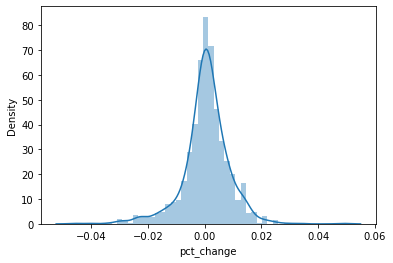

In [11]:
sns.distplot(dia_df.ticker_data['pct_change'].iloc[1:])

In [12]:
from scipy.stats import norm


def plot_qq_normal_plot(true_data, fitted_data, plot_title='True Data vs Normal'):
    plt.figure()
    stats.probplot(true_data, dist="norm", plot=plt, sparams=(mu, sigma))
    plt.title(plot_title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.show()
    


In [22]:
def plot_log_normal_fit_check(data, title=''): 

    # data = dia_df.ticker_data['pct_change'].iloc[1:]
    pdf_estimation = dt.estimate_pdf(data)
    pdf_fitted_lognormal = dt.get_fitted_pdf_log_normal(data)

    rmse = dt.rmse(pdf_estimation, pdf_fitted_lognormal)
    print(rmse)
    plt.plot(pdf_fitted_lognormal, label='LogNormal Fit on Data')
    plt.plot(pdf_estimation, label='True Data PDF')
    plt.title(title)
    plt.legend()
    plt.show()

    shape, loc, scale = lognorm.fit(data)
    # Create the lognormal distribution with the fitted parameters
    fitted_lognorm = lognorm(s=shape, loc=loc, scale=scale)
    fitted_data=  fitted_lognorm.rvs(100000)

    dt.plot_qq_plot(data, fitted_data, plot_title=title)
    


def plot_normal_fit_check(data, title=''): 
    mu, sigma = np.mean(data), np.std(data)
    fitted_normal = stats.norm(loc=mu, scale=sigma)
    fitted_data = fitted_normal.rvs(100000)

    pdf_estimation = dt.estimate_pdf(data)
    pdf_fitted_normal = dt.get_fitted_pdf_normal(data)

    rmse = dt.rmse(pdf_estimation, pdf_fitted_normal)
    print(f"rmse:{rmse}")
    plt.plot(pdf_fitted_normal, label='Normal Fit on Data')
    plt.plot(pdf_estimation, label='True Data PDF')
    plt.title(f"Comparison of PDF of True Data vs other distributions, rmse:{np.round(rmse,2)}")
    plt.legend()
    plt.show()
    
    dt.plot_qq_plot(data, fitted_data, plot_title=title)    

In [24]:
tickers

['DIA', 'QQQ', 'SPY']

rmse:5.86758656281914


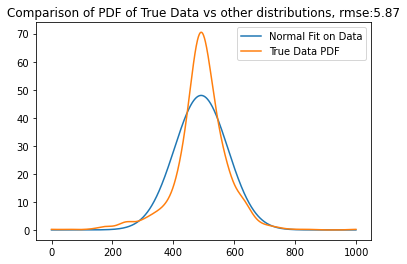

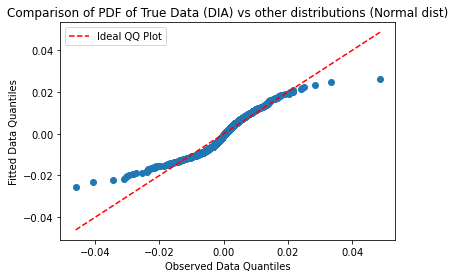

5.8316566359462625


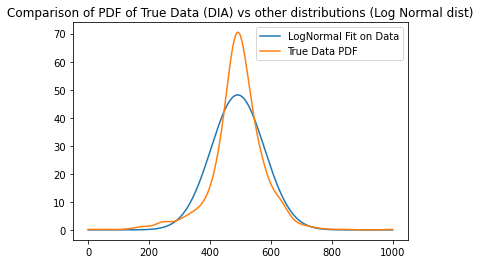

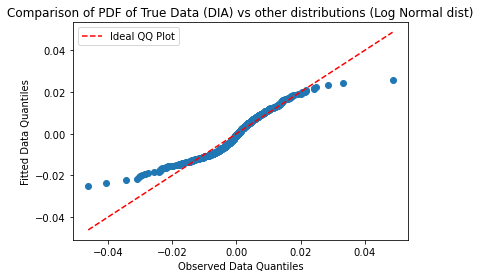

rmse:3.6080590312227523


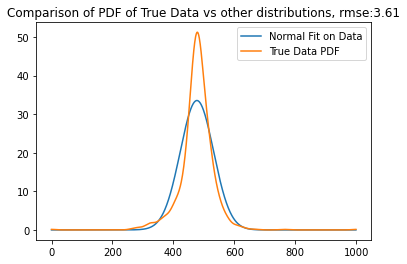

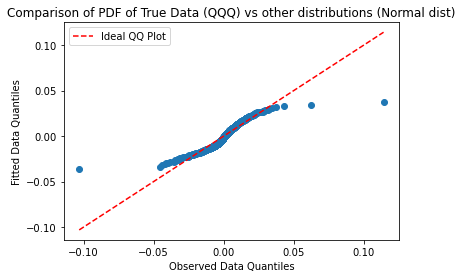

3.617140713438791


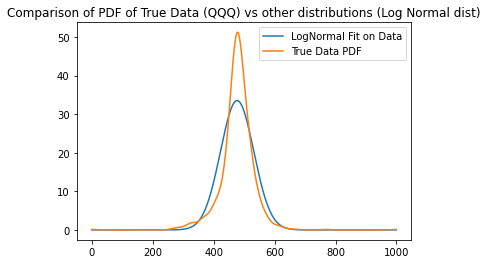

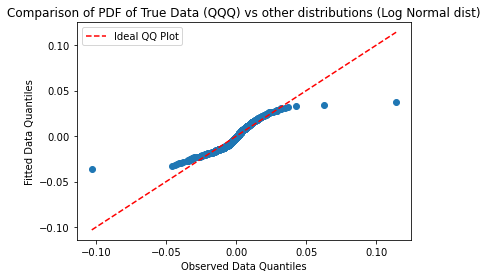

rmse:6.180390117037497


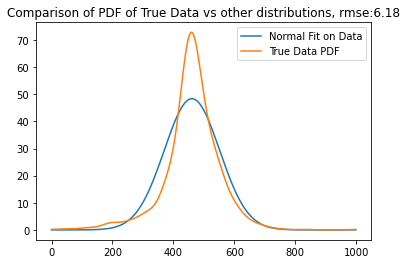

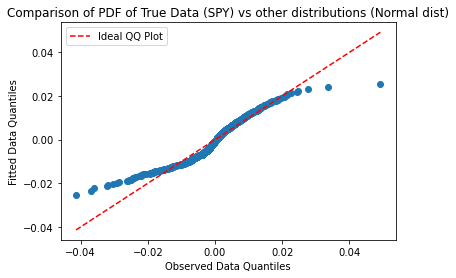

6.205348562768304


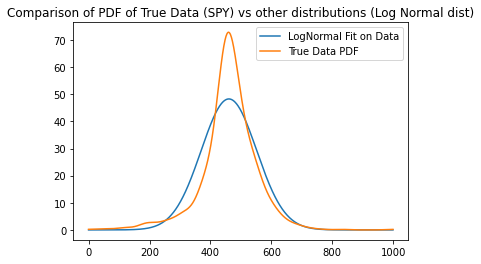

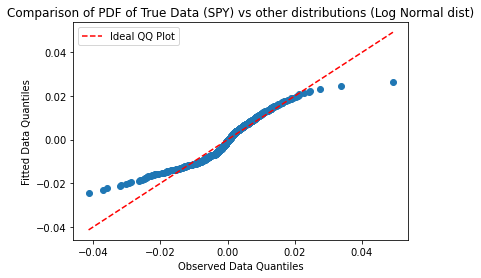

In [28]:

    
    
data = dia_df.ticker_data['pct_change'].iloc[1:]  # Replace with your actual data
plot_normal_fit_check(data, title=f"Comparison of PDF of True Data (DIA) vs other distributions (Normal dist)" )
plot_log_normal_fit_check(data, title=f"Comparison of PDF of True Data (DIA) vs other distributions (Log Normal dist)" )




data = qqq_df.ticker_data['pct_change'].iloc[1:]  # Replace with your actual data
plot_normal_fit_check(data, title=f"Comparison of PDF of True Data (QQQ) vs other distributions (Normal dist)" )
plot_log_normal_fit_check(data, title=f"Comparison of PDF of True Data (QQQ) vs other distributions (Log Normal dist)" )



data = spy_df.ticker_data['pct_change'].iloc[1:]  # Replace with your actual data
plot_normal_fit_check(data, title=f"Comparison of PDF of True Data (SPY) vs other distributions (Normal dist)" )
plot_log_normal_fit_check(data, title=f"Comparison of PDF of True Data (SPY) vs other distributions (Log Normal dist)" )

5.8316566359462625


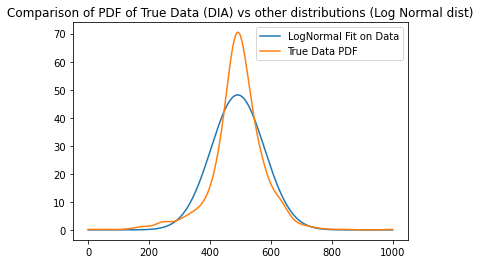

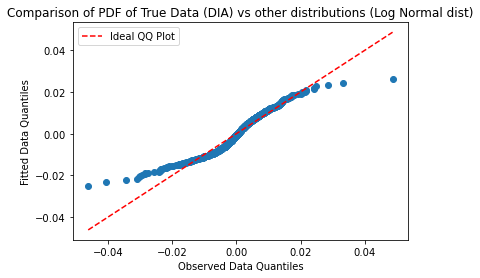

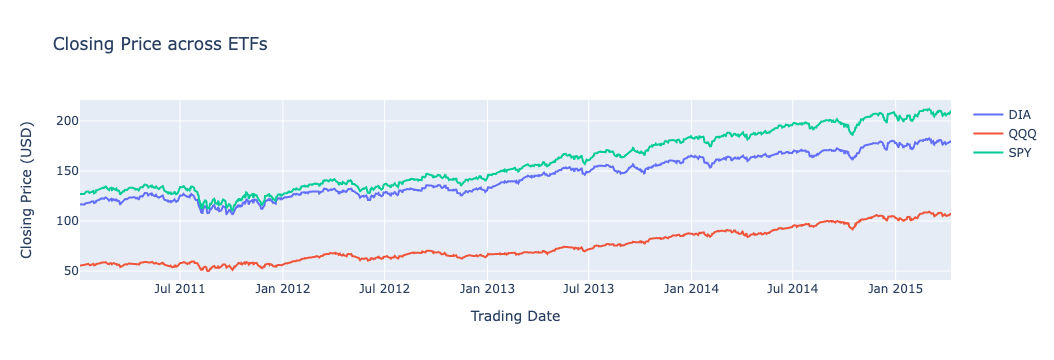

In [21]:
plot.plot_column_across_tickers(df, col_name = 'Close', title='Closing Price across ETFs', yaxis_title='Closing Price (USD)', xaxis_title='Trading Date')

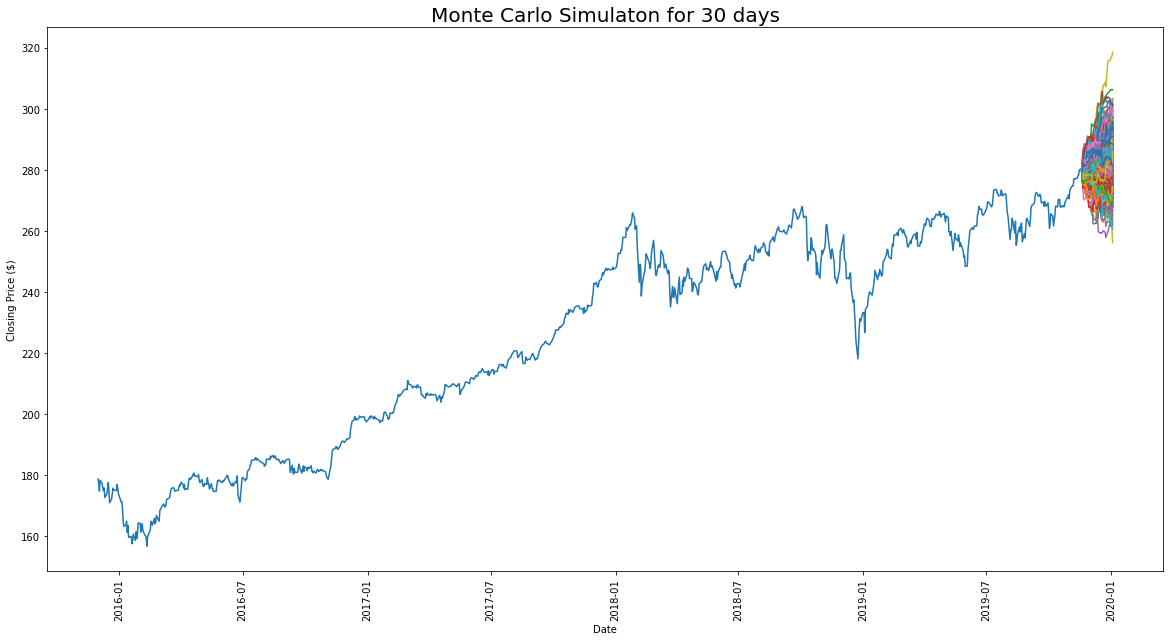

In [30]:
montecarlo_paths = mc.plot_montecarlo_paths(dia_df.ticker_data['pct_change'].iloc[1:], dia_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days',ylabel='Closing Price ($)', xlabel='Date' )

In [31]:
#### Chose a sample predicted path for each of the stocks, try out each of the portfolio distributions, see which one has the highest Sharpe Ratio.  
### Choose that distribution. 

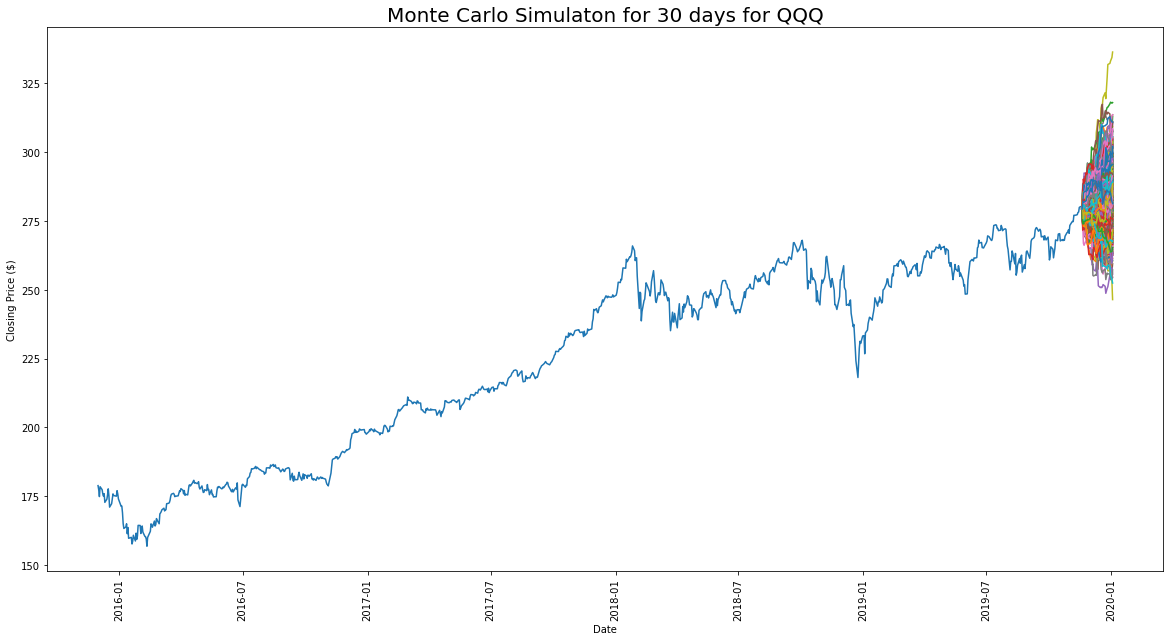

In [32]:
montecarlo_paths = mc.plot_montecarlo_paths(qqq_df.ticker_data['pct_change'].iloc[1:], dia_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for QQQ',ylabel='Closing Price ($)', xlabel='Date' )

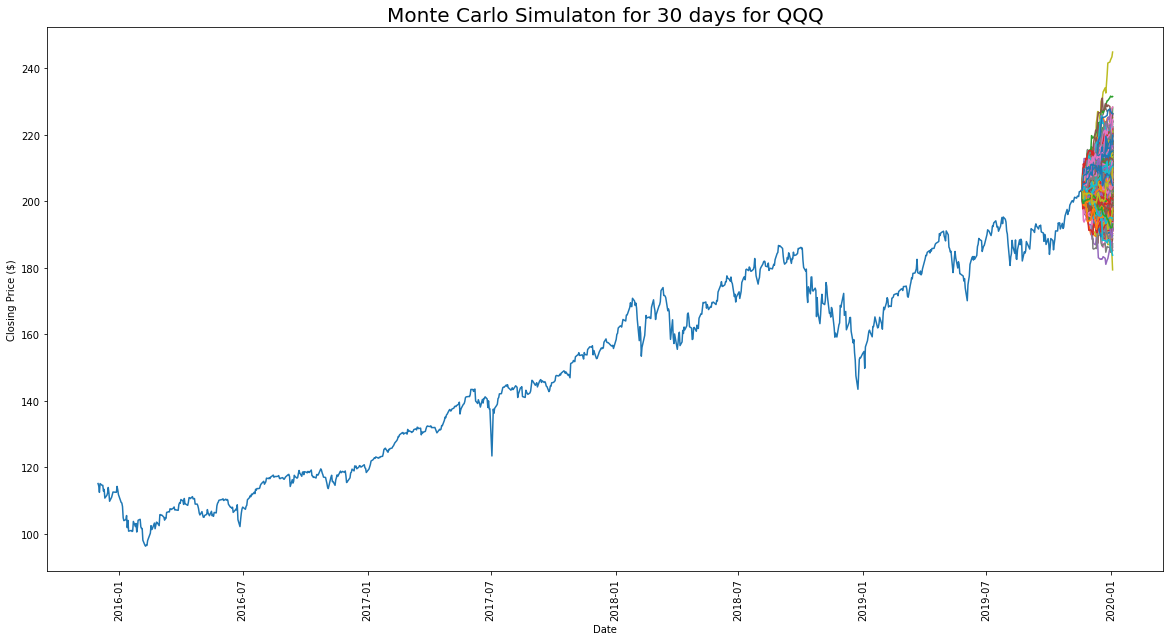

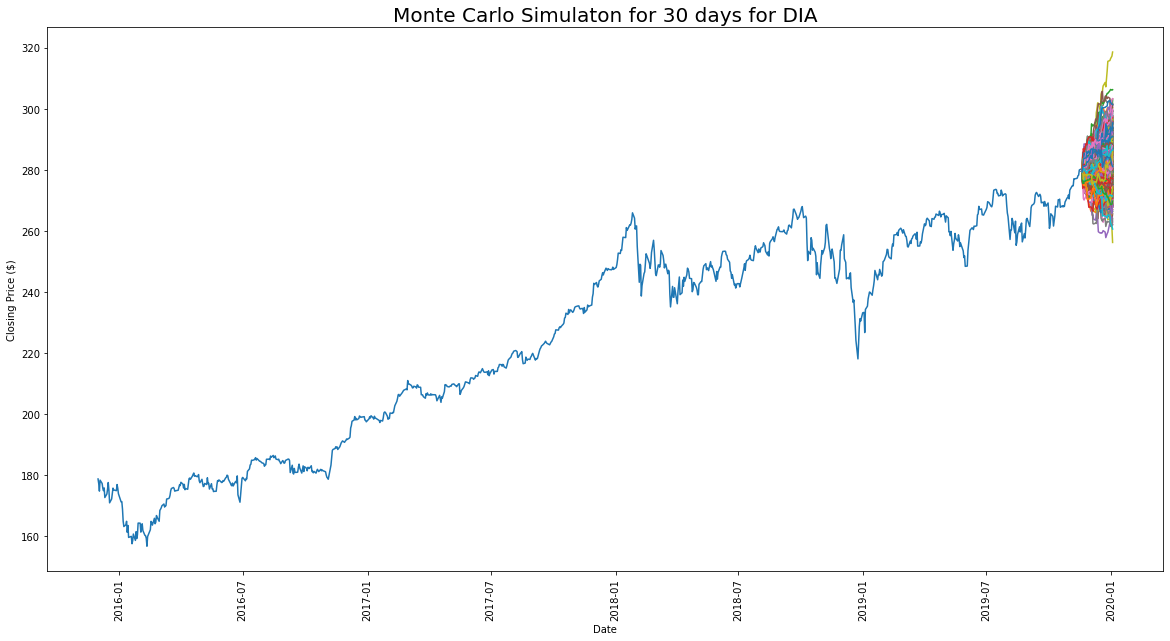

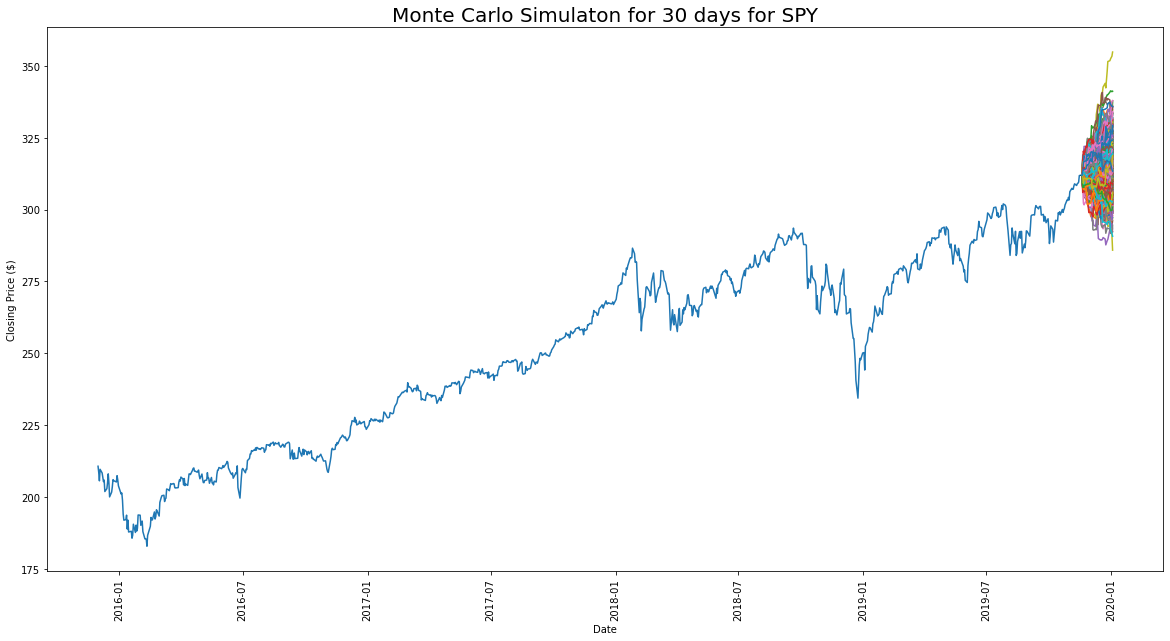

In [33]:
import random 

qqq_paths = mc.plot_montecarlo_paths(qqq_df.ticker_data['pct_change'].iloc[1:], qqq_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for QQQ',ylabel='Closing Price ($)', xlabel='Date' )

dia_paths = mc.plot_montecarlo_paths(dia_df.ticker_data['pct_change'].iloc[1:], dia_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for DIA',ylabel='Closing Price ($)', xlabel='Date' )

spy_paths = mc.plot_montecarlo_paths(spy_df.ticker_data['pct_change'].iloc[1:], spy_df.ticker_data, 'Close',  num_paths=1000, forecast_days=30,\
                      title='Monte Carlo Simulaton for 30 days for SPY',ylabel='Closing Price ($)', xlabel='Date' )

In [38]:
# dt.get_confidence_interval(pd.DataFrame({'simulated_rebalanced_portfolio_returns':simulated_rebalanced_portfolio_returns}), 'simulated_rebalanced_portfolio_returns')


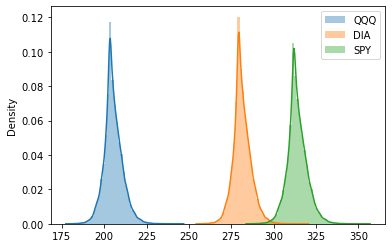

In [39]:
sns.distplot(qqq_paths, label='QQQ')
sns.distplot(dia_paths, label='DIA')
sns.distplot(spy_paths, label='SPY')
plt.legend()

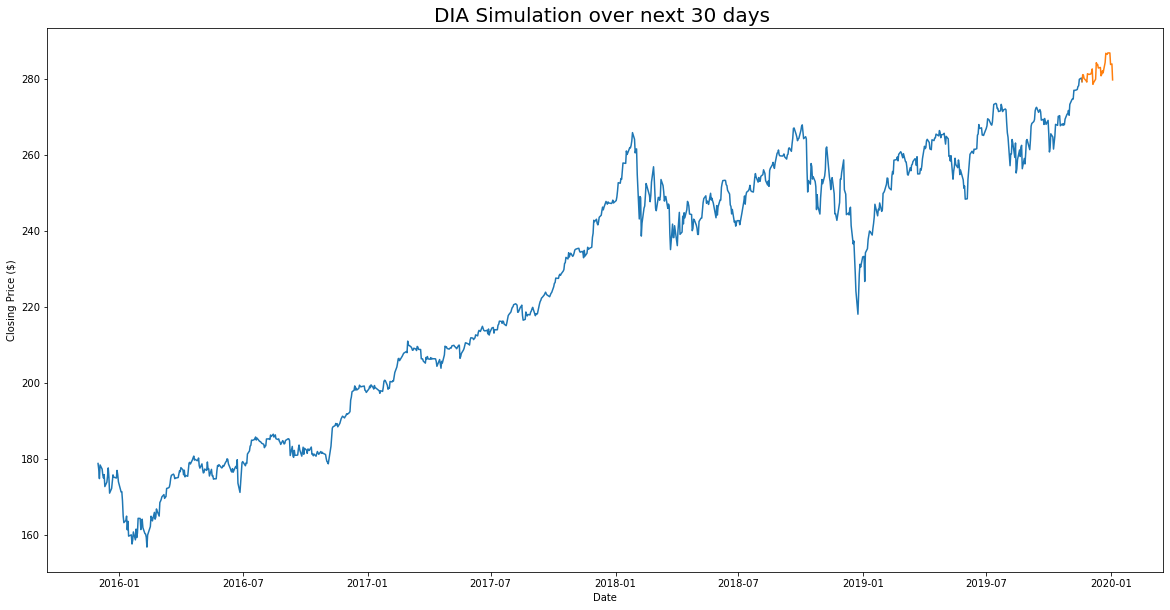

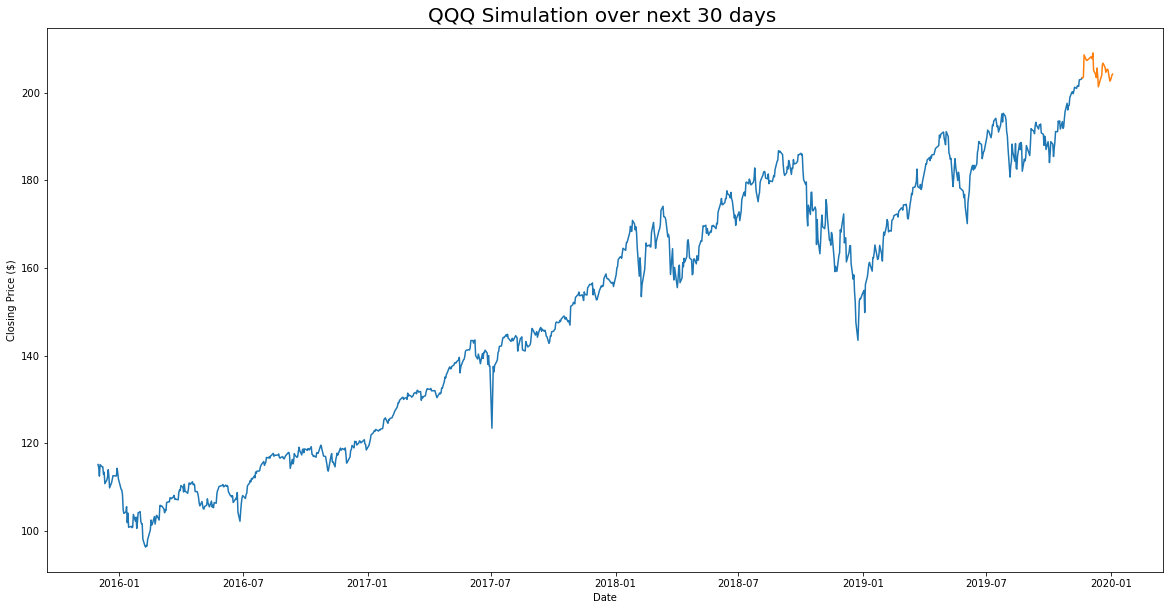

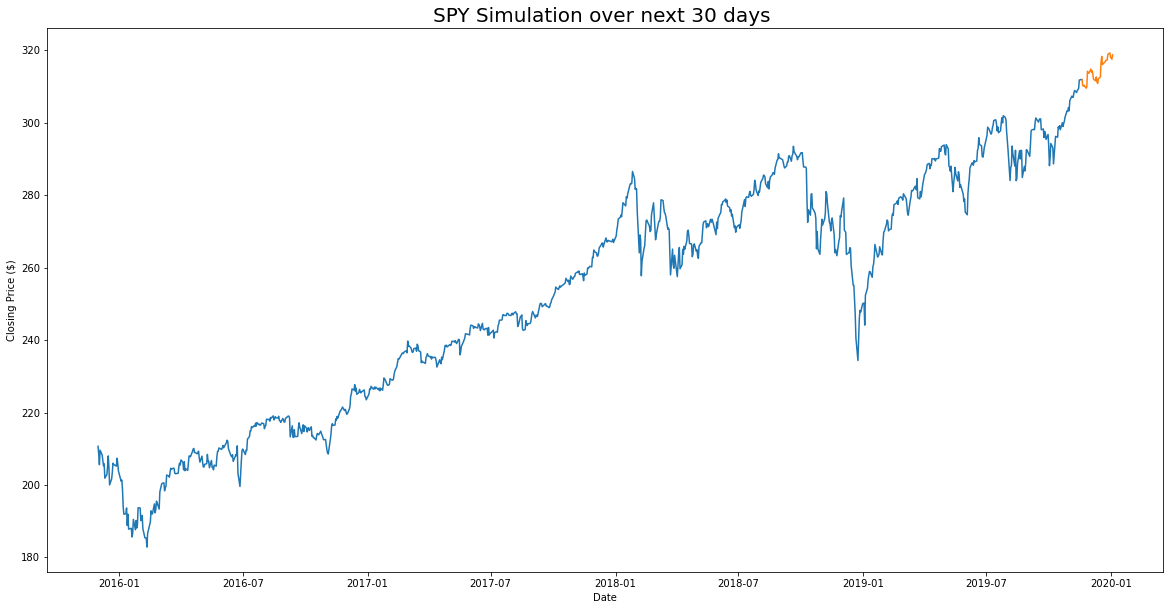

In [42]:

choice_dia = random.choice(dia_paths)
choice_qqq = random.choice(qqq_paths)
choice_spy = random.choice(spy_paths)

mc.plot_possible_mc_path_extension(dia_df.ticker_data, choice_dia, title='DIA Simulation over next 30 days ', xlabel='Date', ylabel='Closing Price ($)')
mc.plot_possible_mc_path_extension(qqq_df.ticker_data, choice_qqq, title='QQQ Simulation over next 30 days ', xlabel='Date', ylabel='Closing Price ($)')
mc.plot_possible_mc_path_extension(spy_df.ticker_data, choice_spy, title='SPY Simulation over next 30 days ', xlabel='Date', ylabel='Closing Price ($)')

get_choice_resource_allocation_df(choice_dia, choice_qqq, choice_spy, num_trading_days=len(montecarlo_paths.T)).reset_index().drop(columns='index').style.background_gradient()

In [43]:
crn_choices = [int(x.round(2)*100) for x in common_random_numbers(1000, seed=10)]

simulations_over_month = []

for i in range(0,1000): 
    if i%50==0: 
        print(i)
    choice_qqq = qqq_paths[crn_choices[i]]
    choice_dia = dia_paths[crn_choices[i]]
    choice_spy = spy_paths[crn_choices[i]]

    simulations_over_month.append(get_choice_resource_allocation_df(choice_qqq, choice_dia, choice_spy, num_trading_days=len(montecarlo_paths.T)))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


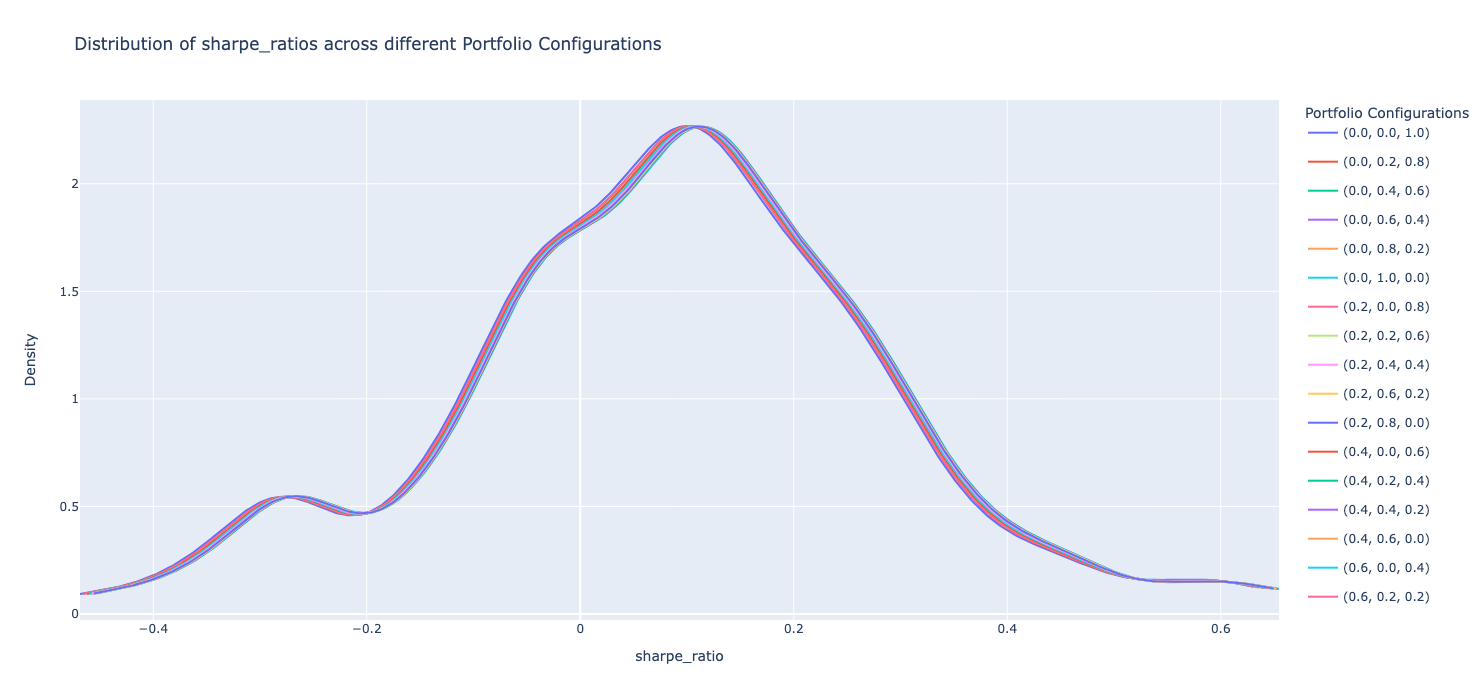

In [54]:
performance_of_portfolio_configs_df = pd.concat(simulations_over_month)
plot_multiple_peformance_distributions(performance_of_portfolio_configs_df, combinations, 'sharpe_ratio', height=700, width=1200)

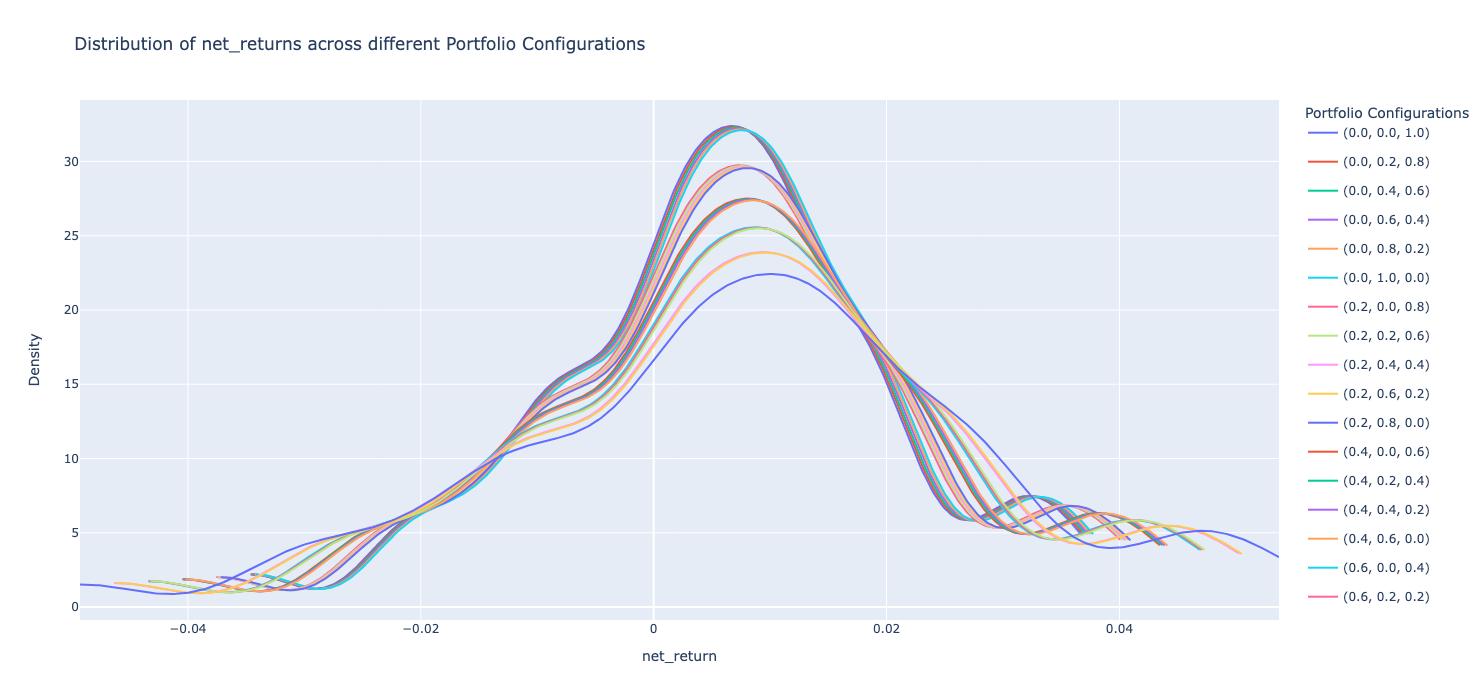

In [55]:
plot_multiple_peformance_distributions(performance_of_portfolio_configs_df, combinations, 'net_return', height=700, width=1200)

In [46]:
best_policy = find_best_policy(performance_of_portfolio_configs_df, combinations, performance_metric='sharpe_ratio')
best_policy = ast.literal_eval(best_policy)
print("Best policy based on net return:", best_policy)

Best policy based on net return: (0.0, 1.0, 0.0)


In [56]:
best_policy = find_best_policy(performance_of_portfolio_configs_df, combinations, performance_metric='net_return')
best_policy = ast.literal_eval(best_policy)
print("Best policy based on net return:", best_policy)

Best policy based on net return: (1.0, 0.0, 0.0)


In [47]:
### Assuming we have the best policy, we rebalance our portfolio based on that and generate a possible 

In [48]:
# crn_choices = [int(x.round(2)*100) for x in common_random_numbers(100, seed=10)]
i = 0

simulated_rebalanced_portfolio_returns = []
for i in range(0,len(crn_choices)): 
    if i%50==0: 
        print(i)
    choice_qqq = qqq_paths[crn_choices[i]]
    choice_dia = dia_paths[crn_choices[i]]
    choice_spy = spy_paths[crn_choices[i]]

    start_date = pd.to_datetime(qqq_df.ticker_data.index)[-1]
    n = len(choice_qqq)
    trading_days = ts.get_trading_days(start_date, n)
    choice_df = pd.DataFrame({'Date':trading_days, 'Close_DIA':choice_dia, 'Close_QQQ':choice_qqq, 'Close_SPY':choice_spy})# trading_days

    simulated_rebalanced_portfolio_df = simulate_portfolio_value(choice_df, best_policy)
    simulated_rebalanced_portfolio_return = (simulated_rebalanced_portfolio_df['portfolio_value'].iloc[-1]-simulated_rebalanced_portfolio_df['portfolio_value'].iloc[0])/simulated_rebalanced_portfolio_df['portfolio_value'].iloc[0]
    simulated_rebalanced_portfolio_returns.append(simulated_rebalanced_portfolio_return)
    

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [58]:
# sns.distplot(simulated_rebalanced_portfolio_returns)

# dt.get_confidence_interval(pd.DataFrame({'simulated_rebalanced_portfolio_returns'}) , 'net_return')


In [60]:
# temp_df

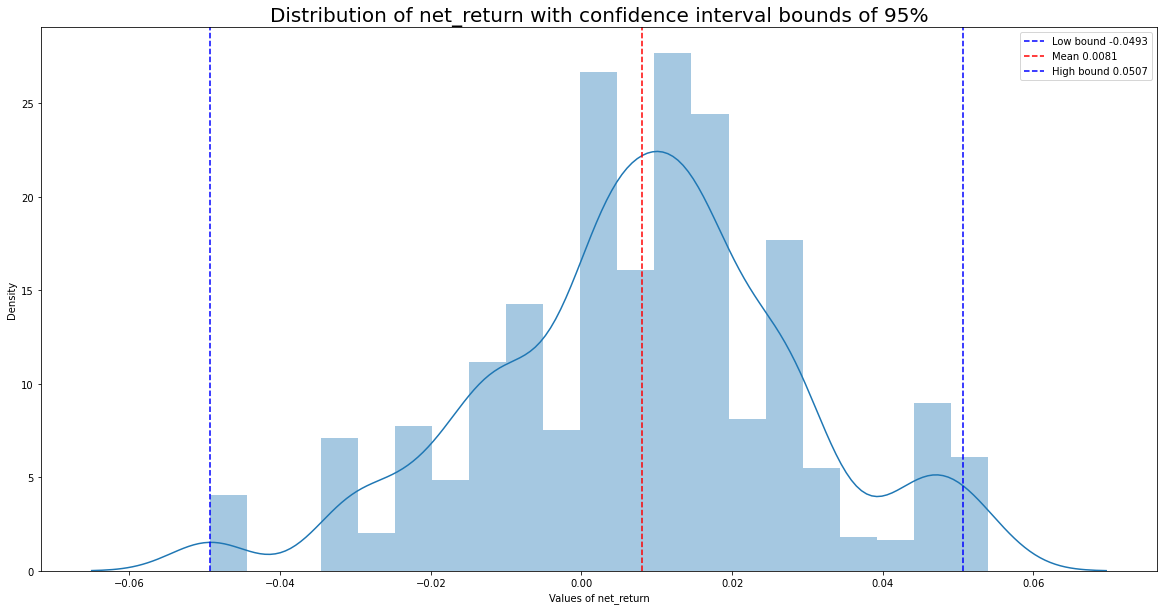

(-0.04927023768957952, 0.00810565420981024, 0.0506670994230637)

In [66]:
temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config'] == str(best_policy)]


dt.get_confidence_interval(temp_df , 'net_return')


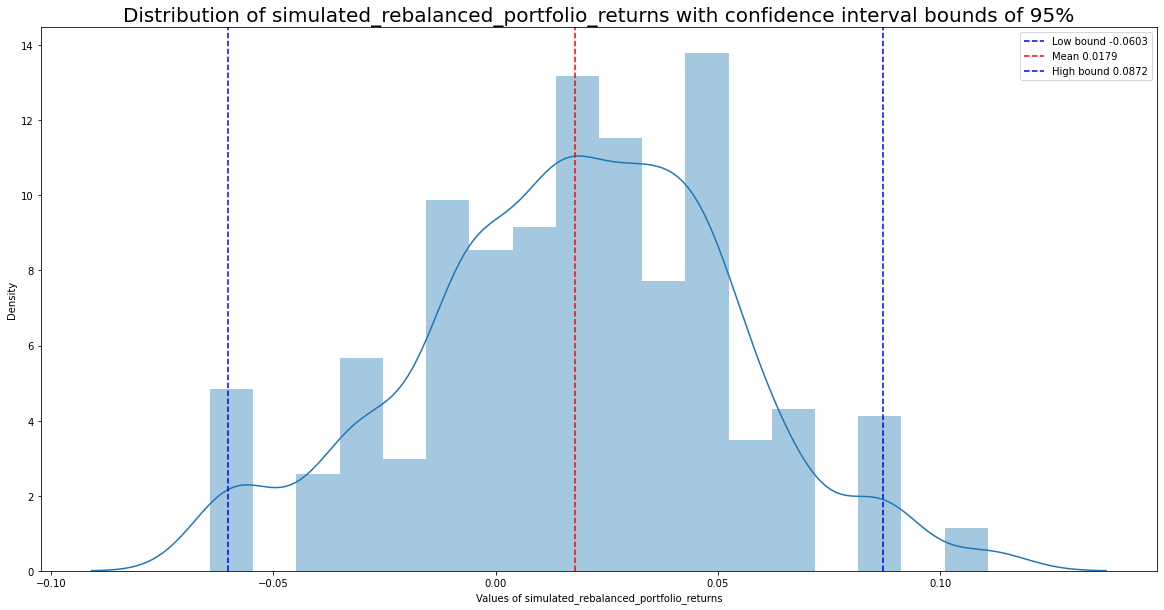

(-0.06027165577068172, 0.01786802664457357, 0.08715410867242462)

In [67]:

dt.get_confidence_interval(pd.DataFrame({'simulated_rebalanced_portfolio_returns':simulated_rebalanced_portfolio_returns}), 'simulated_rebalanced_portfolio_returns')
# sns.distplot(simulated_rebalanced_portfolio_returns, label='Distribution of Returns from Simulated Rebalanced Portfolio')

In [68]:
def simulate_portfolio_value(input_df, combination): 

    for i in range(0,len(combination)): 
        input_df[f'weight_{tickers[i]}'] = combination[i]

    for ticker in tickers: 
        input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

    portfolio_values = []
    for i in range(0,len(input_df)): 
        portfolio_value = 0
        for ticker in tickers: 
            portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
        portfolio_values.append(portfolio_value)
    portfolio_values

    input_df['portfolio_value'] = portfolio_values

    return input_df

In [69]:
sim_df = pd.DataFrame({'date':trading_days, 'Close_QQQ': choice_qqq, 'Close_DIA':choice_dia, 'Close_SPY':choice_spy})
simulated_portfolio_values.append((combinations[i], simulate_portfolio_value(sim_df, combinations[i])['portfolio_value']))


NameError: name 'simulated_portfolio_values' is not defined

In [70]:

get_choice_resource_allocation_df(choice_qqq, choice_dia, choice_spy, num_trading_days=len(montecarlo_paths.T)).reset_index().drop(columns='index').style.background_gradient()

In [ ]:
break 

In [ ]:
# import pandas as pd
# import numpy as np
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Assuming you have the following dataframe
# # performance_of_portfolio_configs_df = pd.concat(simulations_over_month)

# alpha = 0.05

# # Prepare the data for the Tukey HSD test
# net_returns = []
# policy_labels = []

# for i in range(len(combinations)):
#     combination_str = str(combinations[i])
#     temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config'] == combination_str]
    
#     net_returns.extend(temp_df['net_return'].tolist())
#     policy_labels.extend([combination_str] * len(temp_df))

# # Perform the Tukey HSD test
# tukey_result = pairwise_tukeyhsd(net_returns, policy_labels, alpha=alpha)

# # Get the list of comparisons with significant differences
# significantly_different_comparisons = [comparison for comparison in tukey_result.reject if comparison]

# # Find the best policy
# best_policy = max(set(policy_labels), key=lambda policy: np.mean([net_returns[i] for i in range(len(net_returns)) if policy_labels[i] == policy]))

# # Identify the subset of "good" policies
# good_policies = [policy for policy in set(policy_labels) if not any([best_policy in comparison and policy in comparison for comparison in significantly_different_comparisons])]

# print("Good policies based on net return:", good_policies)


In [ ]:
best_policy

In [ ]:
dt.get_confidence_interval(pd.DataFrame({'closing price last day':[x[-1] for x in montecarlo_paths]}), 'closing price last day')

In [ ]:
def generate_combinations(step=0.2, target_sum=1.0, num_variables=3, precision=1):
    combinations = []
    num_steps = int(target_sum / step) + 1

    for i in range(num_steps):
        for j in range(num_steps - i):
            k = num_steps - i - j - 1
            if round(i * step, precision) + round(j * step, precision) + round(k * step, precision) == target_sum:
                combinations.append((round(i * step, precision), round(j * step, precision), round(k * step, precision)))

    return combinations

combinations = generate_combinations()
print(combinations)

combinations_df = pd.DataFrame(combinations, columns=tickers)
combinations_df


In [ ]:
initial_budget =10000

def simulate_portfolio_value(input_df, combination): 

    for i in range(0,len(combination)): 
        input_df[f'weight_{tickers[i]}'] = combination[i]

    for ticker in tickers: 
        input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

    portfolio_values = []
    for i in range(0,len(input_df)): 
        portfolio_value = 0
        for ticker in tickers: 
            portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
        portfolio_values.append(portfolio_value)
    portfolio_values

    input_df['portfolio_value'] = portfolio_values

    return input_df

In [ ]:
combinations[0]

In [ ]:
simulate_portfolio_value(merged_df.iloc[1:], (combinations[1]))

In [ ]:
# plt.figure(figsize=(20,10))

# simulated_portfolio_values = []
# for i in range(0,len(combinations)): 
#     simulated_portfolio_values.append((combinations[i], simulate_portfolio_value(merged_df, combinations[i])['portfolio_value']))
# simulated_portfolio_values

# for i in range(0,len(simulated_portfolio_values)): 
#     plt.plot(pd.to_datetime(simulated_portfolio_values[i][1].index), simulated_portfolio_values[i][1].values, label=str(simulated_portfolio_values[i][0]))
    
    
# plt.axhline(y=10000, color='r',  ls='--', label=f'simulated initial budget of ${initial_budget}')

# plt.legend(loc='upper right', title='Weights for dia, SPY and QQQ resp.', bbox_to_anchor=(1.2, 1.0))
# plt.xticks(rotation=90)
# plt.title(f"Simulation of portfolio value under different weights for stocks dia, SPY and QQQ from {start_dt} to {end_dt}", fontsize=20)
# plt.xlabel("Trading Date")
# plt.ylabel("Portfolio Value in USD $")

